In [2]:
import datetime
import numpy as np
import os
import pandas as pd
import re
import requests
import sys
import xarray as xr

from bs4 import BeautifulSoup
from erddapy import ERDDAP
from erddapy.url_handling import urlopen
from matplotlib import pyplot as plt
from requests.adapters import HTTPAdapter
from tqdm import tqdm
from urllib3.util import Retry

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('seaborn-white')

In [3]:
# OOI Data Explorer Gold Copy ERDDAP
server = "http://erddap-goldcopy.dataexplorer.oceanobservatories.org/erddap"
protocol = "tabledap"

In [4]:
# Setup the erddapy object and a requests session for further, global use
OOI = ERDDAP(server=server, protocol=protocol)

# setup constants used to access the data from the different M2M interfaces
SESSION = requests.Session()
retry = Retry(connect=5, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
SESSION.mount('https://', adapter)

In [5]:
%%time

# search for the stream of interest and load the results into a dataframe
stream = 'ctdbp_no_sample'
search_url = OOI.get_search_url(response='csv', search_for=stream)
df = pd.read_csv(urlopen(search_url))

# limit to just the CTDBP data and split into CE02SHBP and CE04OSBP
ctdbp = df[df['Dataset ID'].str.contains(stream)].reset_index()
ce02 = ctdbp[ctdbp['Dataset ID'].str.contains('CE02SHBP')].reset_index()
ce04 = ctdbp[ctdbp['Dataset ID'].str.contains('CE04OSBP')].reset_index()

# show some results
ce02[['Institution', 'Dataset ID','tabledap']]

CPU times: user 23.9 ms, sys: 4.9 ms, total: 28.8 ms
Wall time: 5.22 s


,Institution,Dataset ID,tabledap
0,Ocean Observatories Initiative,CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-st...,http://erddap-goldcopy.dataexplorer.oceanobser...
1,Ocean Observatories Initiative,CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-st...,http://erddap-goldcopy.dataexplorer.oceanobser...
2,Ocean Observatories Initiative,CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-st...,http://erddap-goldcopy.dataexplorer.oceanobser...
3,Ocean Observatories Initiative,CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-st...,http://erddap-goldcopy.dataexplorer.oceanobser...
4,Ocean Observatories Initiative,CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-st...,http://erddap-goldcopy.dataexplorer.oceanobser...
5,Ocean Observatories Initiative,CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-st...,http://erddap-goldcopy.dataexplorer.oceanobser...


In [6]:
%%time

# Create the data download request URL based on a dataset ID from CE02SHBP
min_time = '2014-10-01T00:00:00.000Z'
max_time = '2014-10-31T23:59:59.999Z'
OOI.constraints = {'time>=': min_time, 'time<=': max_time}
OOI.dataset_id = ce02['Dataset ID'].values[0]
OOI.variables = [ 
    'time',
    'deployment',
    'oxygen',
    'oxy_calphase',
    'oxy_temp',
    'ctd_tc_oxygen',
    'seawater_temperature',
    'ctdbp_no_seawater_pressure',
    'practical_salinity',
    'density'
]
url = OOI.get_download_url(response='nc')
print(url)

# use the requests module to download the data to a local NetCDF file 
r = SESSION.get(url)
if r.status_code == 200:
    with open('dataset.nc', 'wb') as nc:
        nc.write(r.content)

    # load the data into an xarray dataset and set time as the dimension
    data = xr.load_dataset('dataset.nc')
    data = data.swap_dims({'row': 'time'})
    data = data.reset_coords()
    os.remove('dataset.nc')

http://erddap-goldcopy.dataexplorer.oceanobservatories.org/erddap/tabledap/CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-streamed-deployment0001.nc?time,deployment,oxygen,oxy_calphase,oxy_temp,ctd_tc_oxygen,seawater_temperature,ctdbp_no_seawater_pressure,practical_salinity,density&time>=1412121600.0&time<=1414799999.999
CPU times: user 3.37 s, sys: 922 ms, total: 4.3 s
Wall time: 4min 14s


In [7]:
%%time 
# burst average the data into 15-minute, median averages
burst = data.resample(time='900s', base=3150, loffset='450s', keep_attrs=True).median()

# reset the attributes...which keep_attrs should do...
burst.attrs = data.attrs
for v in burst.variables:
    burst[v].attrs = data[v].attrs

burst

CPU times: user 4.19 s, sys: 0 ns, total: 4.19 s
Wall time: 4.19 s


<xarray.Dataset>
Dimensions:                     (time: 2977)
Coordinates:
  * time                        (time) datetime64[ns] 2014-10-01 ... 2014-11-01
Data variables:
    deployment                  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    oxygen                      (time) float64 1.618e+06 1.615e+06 ... 2.656e+06
    oxy_calphase                (time) float64 3.56e+04 3.562e+04 ... 2.551e+04
    oxy_temp                    (time) float64 2.219e+04 2.22e+04 ... 3.107e+04
    ctd_tc_oxygen               (time) float32 151.82825 151.52176 ... 255.6305
    seawater_temperature        (time) float32 8.523284 8.526181 ... 13.925024
    ctdbp_no_seawater_pressure  (time) float32 82.02255 82.01615 ... 81.548965
    practical_salinity          (time) float32 33.535034 33.53484 ... 32.49523
    density                     (time) float32 1026.4232 1026.4226 ... 1024.6384
Attributes:
    AssetManagementRecordLastModified:  2020-08-14T18:41:25.977000
    AssetUniqueID:                      ATOSU-69827-00003
    cdm_data_type:                      Other
    collection_method:                  streamed
    Conventions:                        CF-1.6, NCCSV-1.0
    creator_name:                       Ocean Observatories Initiative
    creator_url:                        http://oceanobservatories.org/
    date_created:                       2020-08-16T06:52:07.210Z
    date_modified:                      2020-08-16T06:52:07.210Z
    defaultDataQuery:                   oxy_calphase,practical_salinity,ctdbp...
    Description:                        CTD Pumped: CTDBP Series N
    feature_Type:                       point
    FirmwareVersion:                    Not specified.
    geospatial_lat_resolution:          0.1
    geospatial_lat_units:               degrees_north
    geospatial_lon_resolution:          0.1
    geospatial_lon_units:               degrees_east
    geospatial_vertical_positive:       down
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_units:          meters
    history:                            2020-08-16T06:52:07.209781 generated ...
    id:                                 CE02SHBP-LJ01D-06-CTDBPN106-streamed-...
    infoUrl:                            http://oceanobservatories.org/
    institution:                        Ocean Observatories Initiative
    lat:                                44.637
    license:                            The data may be used and redistribute...
    lon:                                -124.30587
    Manufacturer:                       Sea-Bird Electronics
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    Mobile:                             False
    ModelNumber:                        SBE 16plus V2
    naming_authority:                   org.oceanobservatories
    nodc_template_version:              NODC_NetCDF_TimeSeries_Orthogonal_Tem...
    node:                               LJ01D
    Notes:                              Not specified.
    Owner:                              Not specified.
    processing_level:                   L2
    project:                            Ocean Observatories Initiative
    publisher_name:                     Ocean Observatories Initiative
    publisher_url:                      http://oceanobservatories.org/
    references:                         More information can be found at http...
    RemoteResources:                    []
    requestUUID:                        4bec44ee-cae8-4eea-b519-134467c4250a
    sensor:                             06-CTDBPN106
    SerialNumber:                       16-7248
    ShelfLifeExpirationDate:            Not specified.
    SoftwareVersion:                    Not specified.
    source:                             CE02SHBP-LJ01D-06-CTDBPN106-streamed-...
    sourceUrl:                          http://oceanobservatories.org/
    standard_name_vocabulary:           NetCDF Climate and Forecast (CF) Meta...
    stream:                             ctdbp_no_samp

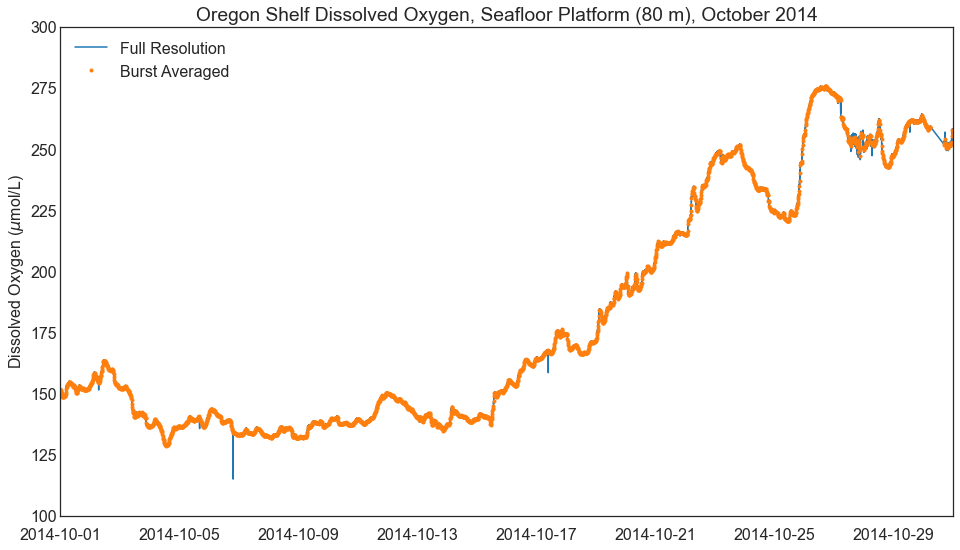

In [8]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 16, 'xtick.major.pad': 12})
plt.plot(data.time, data.ctd_tc_oxygen, '-', label='Full Resolution')
plt.plot(burst.time, burst.ctd_tc_oxygen, '.', label='Burst Averaged')
plt.title('Oregon Shelf Dissolved Oxygen, Seafloor Platform (80 m), October 2014')
plt.ylabel(r'Dissolved Oxygen ($\mu$mol/L)')
plt.xlim(datetime.date(2014, 10, 1), datetime.date(2014, 10, 31))
plt.ylim(100, 300)
plt.legend()

plt.show()

In [30]:
def gc_thredds_collect(dataset_id, tag='.*\\.nc$'):
    """
    Use a regex tag combined with the dataset ID to collect data from the OOI Gold Copy
    THREDDS catalog. The collected data is gathered into an xarray dataset for further
    processing.

    :param dataset_id: dataset ID as a string
    :param tag: regex tag to use in discriminating the data files, so we only collect the correct ones
    :return: the collected data as an xarray dataset
    """
    # construct the THREDDS catalog URL based on the dataset ID sans the deployment string
    url = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHBP-LJ01D-06-CTDBPN106-streamed-ctdbp_no_sample/catalog.html'
    
    # Create a list of the files from the request above using a simple regex as a tag to discriminate the files
    files = list_files(url, tag)

    # Process the data files found above and concatenate into a single data set
    print('Downloading %d data file(s) from the OOI Gold Copy THREDSS catalog' % len(files))
    frames = []
    with tqdm(total=len(files), desc='Waiting', file=sys.stdout) as bar:
        for f in files:
            frames.append(process_file(f))
            bar.update()
            bar.refresh()

    if not frames:
        return None

    # merge the frames into a single data set, preserving global attributes from the first file if more than one.
    m2m = frames[0]
    if len(frames) > 1:
        try:
            # concatenation handles 99% of the cases
            m2m = xr.concat(frames, dim='time')
        except ValueError:  # unless there are missing variables ...
            for i in range(1, len(frames)):
                try:
                    # merging will address most of the remaining cases
                    m2m = m2m.merge(frames[i])
                except ValueError:
                    # but sometimes there just really is something wrong with a dataset
                    message = "Corrupted data in file {} of {}, skipping merge of this file".format(i+1, len(frames))
                    warnings.warn(message)

    m2m = m2m.sortby('deployment')
    m2m.attrs['time_coverage_start'] = ('%sZ' % m2m.time.min().values)
    m2m.attrs['time_coverage_end'] = ('%sZ' % m2m.time.max().values)
    m2m.attrs['time_coverage_resolution'] = ('P%.2fS' % (np.mean(m2m.time.diff('time').values).astype(float) / 1e9))

    return m2m

def list_files(url, tag='.*\\.nc$'):
    """
    Function to create a list of the NetCDF data files in the THREDDS catalog created by a request to the M2M system.

    :param url: URL to user's THREDDS catalog specific to a data request
    :param tag: regex pattern used to distinguish files of interest
    :return: list of files in the catalog with the URL path set relative to the catalog
    """
    page = SESSION.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    pattern = re.compile(tag)
    return [node.get('href') for node in soup.find_all('a', text=pattern)]


def process_file(catalog_file):
    """
    Function to download one of the NetCDF files as an xarray data set, convert to time as the appropriate dimension
    instead of obs, and drop the extraneous timestamp variables (these were originally not intended to be exposed to
    users and lead to confusion as to their meaning). The ID and provenance variables are better off obtained directly
    from the M2M system via a different process. Having them included imposes unnecessary constraints on the processing.

    :param catalog_file: Unique file, referenced by a URL relative to the catalog, to download and convert the data
        file to an xarray data set.
    :return: downloaded data in an xarray dataset.
    """
    dods_url = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/'
    url = re.sub('catalog.html\?dataset=', dods_url, catalog_file)
    r = SESSION.get(url, stream=True)
    with open('dataset.nc', 'wb') as nc:
        for chunk in r.iter_content(chunk_size=1024*1024):
            nc.write(chunk)
            
    ds = xr.load_dataset('dataset.nc')

    if not ds:
        return None

    # addresses error in how the *_qartod_executed variables are set
    qartod_pattern = re.compile(r'^.+_qartod_executed$')
    for v in ds.variables:
        if qartod_pattern.match(v):
            # the shape of the QARTOD executed variables are problematical, delete for now
            ds = ds.drop_vars(v)

    ds = ds.swap_dims({'obs': 'time'})
    ds = ds.reset_coords()
    keys = ['obs', 'id', 'provenance', 'driver_timestamp', 'ingestion_timestamp',
            'port_timestamp', 'preferred_timestamp']
    for key in keys:
        if key in ds.variables:
            ds = ds.drop_vars(key)
    ds = ds.sortby('time')

    # clear-up some global attributes we will no longer be using
    keys = ['DODS.strlen', 'DODS.dimName', 'DODS_EXTRA.Unlimited_Dimension', '_NCProperties', 'feature_Type']
    for key in keys:
        if key in ds.attrs:
            del(ds.attrs[key])

    if ds.encoding['unlimited_dims']:
        del ds.encoding['unlimited_dims']

    # resetting cdm_data_type from Point/Other to Station and the featureType from point to timeSeries
    ds.attrs['cdm_data_type'] = 'Station'
    ds.attrs['featureType'] = 'timeSeries'

    # update some of the global attributes
    ds.attrs['acknowledgement'] = 'National Science Foundation'
    ds.attrs['comment'] = 'Data collected from the OOI M2M API and reworked for use in locally stored NetCDF files.'

    return ds

In [29]:
%%time
data = gc_thredds_collect(None, '.*deployment0001.*CTDBP.*\\.nc$')

Waiting: 100%|██████████| 6/6 [25:22<00:00, 253.67s/it]
CPU times: user 45.5 s, sys: 22.2 s, total: 1min 7s
Wall time: 25min 28s


In [35]:
%%time 
# burst average the data into 15-minute, median averages
data = data.sortby('time')
burst = data.resample(time='900s', base=3150, loffset='450s', keep_attrs=True).median()

# reset the attributes...which keep_attrs should do...
burst.attrs = data.attrs
for v in burst.variables:
    burst[v].attrs = data[v].attrs

burst

CPU times: user 1min 45s, sys: 0 ns, total: 1min 45s
Wall time: 1min 45s


<xarray.Dataset>
Dimensions:                                        (time: 29663)
Coordinates:
  * time                                           (time) datetime64[ns] 2014...
Data variables:
    oxy_calphase                                   (time) float64 3.581e+04 ....
    practical_salinity                             (time) float64 33.61 ... 3...
    ctdbp_no_seawater_conductivity_qc_executed     (time) float64 29.0 ... 29.0
    ctdbp_no_seawater_pressure_qc_executed         (time) float64 29.0 ... 29.0
    practical_salinity_qartod_results              (time) float64 1.0 ... 1.0
    density_qc_executed                            (time) float64 29.0 ... 29.0
    ctd_tc_oxygen_qc_executed                      (time) float64 1.0 ... 1.0
    conductivity                                   (time) float64 1.403e+06 ....
    ctd_tc_oxygen                                  (time) float64 149.2 ... 1...
    ctdbp_no_seawater_conductivity_qc_results      (time) float64 13.0 ... 13.0
    practical_salinity_qc_results                  (time) float64 29.0 ... 29.0
    temperature                                    (time) float64 4.26e+05 .....
    density                                        (time) float64 1.026e+03 ....
    ctdbp_no_seawater_conductivity_qartod_results  (time) float64 1.0 ... 1.0
    ctdbp_no_seawater_pressure_qc_results          (time) float64 29.0 ... 29.0
    seawater_temperature_qc_results                (time) float64 29.0 ... 13.0
    pressure_temp                                  (time) float64 2.799e+04 ....
    ctd_tc_oxygen_qc_results                       (time) float64 1.0 ... 1.0
    dissolved_oxygen_qc_results                    (time) float64 29.0 ... 29.0
    ctdbp_no_seawater_pressure                     (time) float64 81.83 ... 8...
    seawater_temperature                           (time) float64 8.575 ... 8.04
    ctdbp_no_seawater_conductivity                 (time) float64 3.547 ... 3...
    seawater_temperature_qartod_results            (time) float64 1.0 ... 1.0
    pressure                                       (time) float64 8.599e+06 ....
    deployment                                     (time) float64 1.0 ... 1.0
    ctdbp_no_seawater_pressure_qartod_results      (time) float64 1.0 ... 1.0
    oxygen                                         (time) float64 1.592e+06 ....
    dissolved_oxygen                               (time) float64 117.4 ... 9...
    dissolved_oxygen_qc_executed                   (time) float64 29.0 ... 29.0
    practical_salinity_qc_executed                 (time) float64 29.0 ... 29.0
    oxy_temp                                       (time) float64 2.225e+04 ....
    seawater_temperature_qc_executed               (time) float64 29.0 ... 29.0
    density_qc_results                             (time) float64 13.0 ... 13.0
Attributes:
    node:                               LJ01D
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             ctdbp_no_sample
    featureType:                        timeSeries
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2020-08-16T06:53:20.531021
    keywords:                           
    cdm_data_type:                      Station
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2020-08-16T06:53:20.531015
    id:                                 CE02SHBP-LJ01D-06-CTDBPN106-streamed-...
    requestUUID:                        56563978-02d6-4dd4-86cb-9696a948e249
    contributor_role:                   
    summary:                            Dataset Generated by Stream Engine 

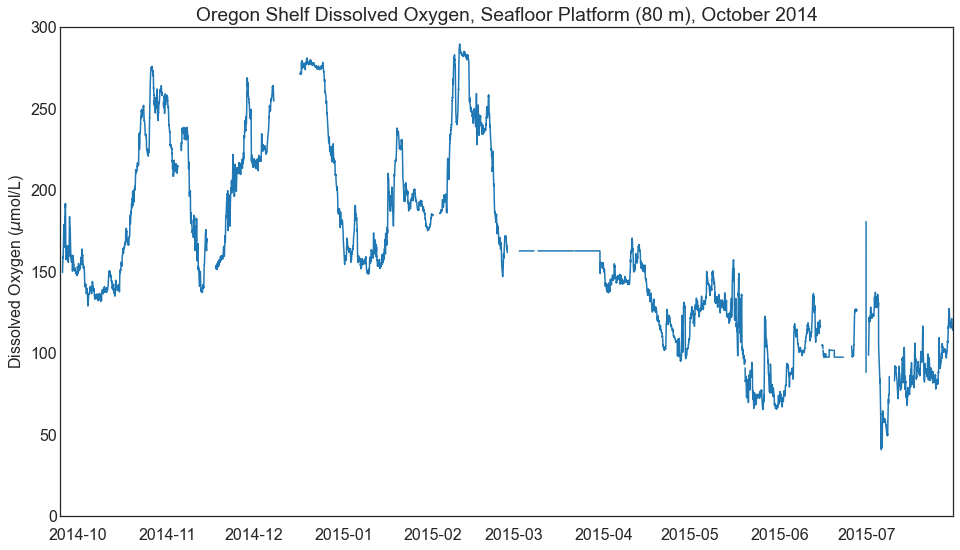

In [38]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 16, 'xtick.major.pad': 12})
plt.plot(burst.time, burst.ctd_tc_oxygen, '-', label='Burst Averaged')
plt.title('Oregon Shelf Dissolved Oxygen, Seafloor Platform (80 m), October 2014')
plt.ylabel(r'Dissolved Oxygen ($\mu$mol/L)')
plt.xlim(datetime.date(2014, 9, 25), datetime.date(2015, 7, 31))
plt.ylim(0, 300)

plt.show()

In [ ]:
def request_data(e):
    # gather the dataset global level attributes
    info_url = e.get_info_url(response='csv')
    info = pd.read_csv(info_url)

    # set the start and end dates and create an array of datetimes to index through the data
    start_date = "".join(info.loc[info["Attribute Name"] == "time_coverage_start", "Value"])
    end_date = "".join(info.loc[info["Attribute Name"] == "time_coverage_end", "Value"])
    dates = pd.date_range(start=start_date, end=end_date, freq='90D', normalize=True, closed='left')

    # use the dates array and parallelize requests for 90 day chunks of the data
    num_cores = multiprocessing.cpu_count()
    datasets = Parallel(n_jobs=num_cores)(
        delayed(erddap_download)(e, date) for date in dates
    )
    
    return datasets

In [ ]:
%%time
# request all of the data for the dataset ID defined above
datasets = request_data(OOI)

In [ ]:
datasets

In [ ]:
# load the data into an xarray dataset and set time as the dimension
data = xr.load_dataset('dataset.nc')
data = data.swap_dims({'row': 'time'})
data = data.reset_coords()

# clean up the temporary file
#os.remove('dataset.nc')

In [ ]:
# burst average the data into 15-minute, median averages
burst = data.resample(time='900s', base=3150, loffset='450s', keep_attrs=True).median()

# reset the attributes...which keep_attrs should do...
burst.attrs = data.attrs
for v in burst.variables:
    burst[v].attrs = data[v].attrs

In [ ]:
burst

In [ ]:
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 16, 'xtick.major.pad': 12})
plt.plot(data.time, (data.oxygen / 10000) - 10, '-', label='Full Resolution')
plt.plot(burst.time, (burst.oxygen / 10000) - 10, '.', label='Burst Averaged')
plt.title('Oregon Shelf Dissolved Oxygen, Seafloor Platform (80 m), Fall 2014')
plt.ylabel(r'Dissolved Oxygen ($\mu$mol/L)')
plt.xlim(datetime.date(2014, 9, 25), datetime.date(2014, 10, 11))
plt.ylim(100, 300)
plt.legend()

plt.show()

In [ ]:
url = 'http://erddap-goldcopy.dataexplorer.oceanobservatories.org/erddap/tabledap/CE02SHBP-LJ01D-06-CTDBPN106-ctdbp_no_sample-streamed-deployment0001.nc4?time,deployment,oxygen,oxy_calphase,oxy_temp,ctd_tc_oxygen,seawater_temperature,ctdbp_no_seawater_pressure,practical_salinity,density&time>=1412121600.0&time<=1414799999.999'
data = xr.open_dataset(url)
data

In [ ]:
r = SESSION.get(url)

In [ ]:
r.status_code

In [ ]:
ce02['Dataset ID'][0]